In [2]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [3]:
num_notes = 128
action_dim = 3*num_notes
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)

# Baseline Transformer definition
Uses absolute position representation

In [174]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Only change is the view/expand in forward (accounts for multiple instruments and batches)
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[1], :].view(1, x.shape[1], 1, -1).expand(x.shape[0], -1, x.shape[2], -1)
        return self.dropout(x)
        

# EnsembleTransformer: takes a history of actions 
# for instruments in an ensemble and generates distributions for the next actions
class EnsembleTransformer(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # action_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # heads: number of attention heads
    # attention_layers: number of attention layers
    # ff_size: size of the feedforward output at the end of the decoder
    # chunk_size: long sequences will be processed in chunks of chunk_size
    def __init__(self, action_dim, embed_dim, num_instruments, heads, attention_layers, ff_size, chunk_size):
        super(EnsembleTransformer, self).__init__()
        
        self.action_dim = action_dim
        self.embed_dim = embed_dim
        self.chunk_size = chunk_size
        
        # We add the tanhed instrument embedding to each input message 
        # (this is the global conditioning idea from DeepJ, which comes from WaveNet)
        self.i_embedding = torch.nn.Embedding(num_instruments, embed_dim)
        
        self.position_encoding = PositionalEncoding(embed_dim)
        
        self.embedding = torch.nn.Linear(action_dim, embed_dim)
        
        # A decoder is used to transform the history of the instrument we're generating
        # music for, then combine this with the other histories to generate the next action
        decoder_layer = torch.nn.TransformerDecoderLayer(embed_dim, heads, ff_size)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, attention_layers)
        
        self.logits = torch.nn.Linear(embed_dim, action_dim)
        
    
    # forward: generates probabilities for the next MIDI actions
    # given the action history of the ensemble
    # ARGUMENTS
    # history: an NxLxBxA tensor, where N is the max number of instruments in the batch,
    # L is the length of the longest history in the batch, B is the batch size,
    # and A is the number of actions
    # mask: an NxLxB tensor, containing True where an action or instrument doesn't exist
    # instruments: a NxB tensor indicating the instrument numbers for each batch
    # RETURN: an NxLxBxA tensor out. out[:, :, :, :2*num_notes] represents the Bernoulli probabilities
    # for note-on and note-off actions. out[:, :, :, 2*num_notes:] represents the velocity of each note
    # assuming it gets turned on. Note that to get the actual values you'll need to take a sigmoid
    def forward(self, history, mask, instruments):
        N = history.shape[0] # max instruments
        L = history.shape[1] # longest length
        B = history.shape[2] # batch size
        A = history.shape[3]
        assert(instruments.shape == (N, B))
        assert(mask.shape == (N, L, B))
        assert(A == self.action_dim)
        
        inputs = self.embedding(history) + torch.tanh(self.i_embedding(instruments)).unsqueeze(1).expand(-1, L, -1, -1)
        
        decoding = torch.zeros((N, L, B, embed_dim))
        
        for start in range(0, L, self.chunk_size):
            end = min(start + chunk_size, L)
            size = end - start
            
            for inst in range(N):
                memory_idx = [i for i in range(N) if i != inst]
                
                tgt_key_padding_mask = mask[inst, start:end].transpose(0, 1)

                tgt_mask = torch.triu(torch.ones((size, size), dtype=torch.bool))
                tgt_mask.fill_diagonal_(False)

                if N == 1:
                    memory = torch.zeros((1, B, self.embed_dim))
                    memory_key_padding_mask = None
                    memory_mask = None
                else:
                    memory = self.position_encoding(inputs[memory_idx, start:end]).view(-1, B, self.embed_dim)
                    memory_key_padding_mask = mask[memory_idx, start:end].view(-1, B).transpose(0, 1)
                    memory_mask = tgt_mask.repeat(1, N - 1)

                decoder_inputs = self.position_encoding(inputs[inst, start:end].unsqueeze(0)).squeeze(0)
                decoding[inst, start:end] = self.decoder(decoder_inputs, \
                                                         memory, \
                                                         tgt_mask=tgt_mask, \
                                                         memory_mask=memory_mask, \
                                                         tgt_key_padding_mask=tgt_key_padding_mask, \
                                                         memory_key_padding_mask=memory_key_padding_mask)

        return self.logits(decoding)

# Tests for baseline transformer
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single instrument's part in a single song (only the first 100 time steps). Tests decoder

In [192]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256
chunk_size = 200

grad_clip = 10

model = EnsembleTransformer(action_dim, embed_dim, num_instruments, heads, attention_layers, ff_size, chunk_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [ ]:
model.load_state_dict(torch.load('overfit_single_instrument.pth'))

In [193]:
recording = np.load('preprocessed_data_sync/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data_sync/instruments318.npy', allow_pickle=True)

inst = 1

max_seq_length = 200

history = torch.tensor(recording[inst, :max_seq_length]).view(1, max_seq_length, 1, -1)
max_instruments = history.shape[0]
mask = torch.zeros((max_instruments, max_seq_length, 1), dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1)

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
bce = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight = 2*torch.ones(2*num_notes))
mse = torch.nn.MSELoss(reduction='none')
epochs = 1000
train_losses = np.zeros(epochs)

targets = history[:, 1:]

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))    
    out = model(history[:, :-1], mask[:, :-1], instruments)
                
    note_losses = bce(out[:, :, :, :2*num_notes], targets[:, :, :, :2*num_notes])
    
    # Only apply dynamics losses to notes that are being turned on
    dynamics_losses = targets[:, :, :, :num_notes]*mse(torch.sigmoid(out[:, :, :, 2*num_notes:]), targets[:, :, :, 2*num_notes:])
    
    loss_mask = torch.logical_not(mask[:, :-1])
    loss = note_losses[loss_mask].mean() + dynamics_losses[loss_mask].mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

Starting epoch 0
Loss: 0.982203
Starting epoch 1
Loss: 0.935216
Starting epoch 2
Loss: 0.895947
Starting epoch 3
Loss: 0.870366
Starting epoch 4
Loss: 0.849073
Starting epoch 5
Loss: 0.829473
Starting epoch 6
Loss: 0.811161
Starting epoch 7
Loss: 0.794440
Starting epoch 8
Loss: 0.779591
Starting epoch 9
Loss: 0.766769
Starting epoch 10
Loss: 0.755947
Starting epoch 11
Loss: 0.746941
Starting epoch 12
Loss: 0.739508
Starting epoch 13
Loss: 0.733396
Starting epoch 14
Loss: 0.728375
Starting epoch 15
Loss: 0.724249
Starting epoch 16
Loss: 0.720855
Starting epoch 17
Loss: 0.718058
Starting epoch 18
Loss: 0.715748
Starting epoch 19
Loss: 0.713835
Starting epoch 20
Loss: 0.712247
Starting epoch 21
Loss: 0.710923
Starting epoch 22
Loss: 0.709817
Starting epoch 23
Loss: 0.708887
Starting epoch 24
Loss: 0.708103
Starting epoch 25
Loss: 0.707439
Starting epoch 26
Loss: 0.706874
Starting epoch 27
Loss: 0.706390
Starting epoch 28
Loss: 0.705974
Starting epoch 29
Loss: 0.705614
Starting epoch 30
Lo

In [110]:
torch.save(model.state_dict(), 'overfit_single_instrument_sync.pth')

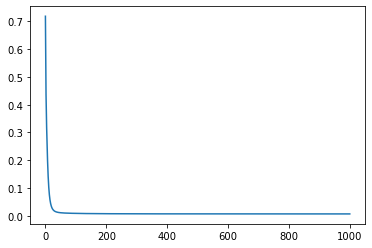

In [137]:
plt.plot(train_losses)

In [194]:
# Sample from model
gen_history = torch.tensor(recording[inst, 0]).view(1, 1, 1, -1)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)
instruments = torch.tensor(instrument_numbers.index(instruments_np[inst]), dtype=torch.long).view(1, 1)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

max_instruments = history.shape[0]

# Move forward in time
wrong_cnt = 0
for t in range(1, max_seq_length):
    #out = model(gen_history, mask, instruments)
    out = torch.sigmoid(model(history[:, :t], mask, instruments))
    
    #next_actions = torch.bernoulli(out[0, -1, :, :2*num_notes]).view(1, 1, 1, -1)
    next_actions = torch.round(out[0, -1, :, :2*num_notes]).view(1, 1, 1, -1)
    next_vels = out[0, -1, :, 2*num_notes:].view(1, 1, 1, -1)
    append = torch.cat((next_actions, next_vels), dim=3)
    gen_history = torch.cat((gen_history, append), dim=1)

    if torch.any(gen_history[:, t, :, :2*num_notes] != history[:, t, :, :2*num_notes]):
        wrong_cnt += 1
    
    mask = torch.cat((mask, torch.zeros((1, 1, 1), dtype=torch.bool)), dim=1)

print(wrong_cnt)

199


In [195]:
print(gen_history[0, -1])

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0

In [118]:
np.save('test_history.npy', gen_history.detach().view(max_instruments, max_seq_length, -1).numpy())
np.save('test_instruments.npy', np.array([instrument_numbers[instruments[0]]]))

Get the model to overfit to two instruments' parts in a single song

In [5]:
model.load_state_dict(torch.load('overfit_two_instruments.pth'))

<All keys matched successfully>

In [ ]:
recording = np.load('preprocessed_data_sync/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data_sync/instruments318.npy', allow_pickle=True)

max_seq_length = 200

history = torch.tensor(recording[:, :max_seq_length]).view(2, max_seq_length, 1, -1)
max_instruments = history.shape[0]
mask = torch.zeros((max_instruments, max_seq_length, 1), dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(i) for i in instruments_np], dtype=torch.long).view(max_instruments, 1)

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
bce = torch.nn.BCELoss(reduction='none')
mse = torch.nn.MSELoss(reduction='none')
epochs = 300
train_losses = np.zeros(epochs)

targets = history[:, 1:]

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))    
    out = model(history[:, :-1], mask[:, :-1], instruments)
                
    note_losses = bce(out[:, :, :, :2*num_notes], targets[:, :, :, :2*num_notes])
    
    # Only apply dynamics losses to noted that are being turned on
    dynamics_losses = targets[:, :, :, :num_notes]*mse(out[:, :, :, 2*num_notes:], targets[:, :, :, 2*num_notes:])
    
    loss_mask = torch.logical_not(mask[:, :-1])
    loss = note_losses[loss_mask].mean() + dynamics_losses[loss_mask].mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

In [15]:
torch.save(model.state_dict(), 'overfit_two_instruments.pth')

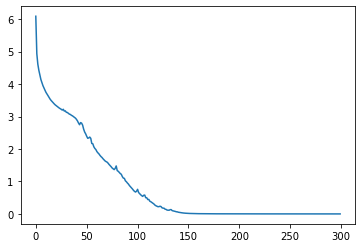

In [16]:
plt.plot(train_losses)

In [ ]:
# Check if each instrument can reconstruct its part, given the other instrument's part
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

for inst in range(max_instruments):
    gen_history = history.clone()

    # Move forward in time
    wrong_cnt = 0
    for t in range(1, max_seq_length):
        input_mask = mask.clone()
        input_mask[t:] = True
        logits = model(gen_history, input_mask, instruments, inst)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        gen_history[t, inst, 0] = torch.multinomial(probs, 1)
        if torch.argmax(probs.flatten()) != history[t, inst].flatten():
            wrong_cnt += 1
            print(torch.topk(probs.flatten(), 10))
            print(history[t, inst])

    print(wrong_cnt)

0


In [ ]:
recording = np.load('preprocessed_data/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data/instruments318.npy', allow_pickle=True)

max_seq_length = 1000
max_instruments = instruments_np.shape[0]
batch_size = 1

history = torch.zeros((max_seq_length, max_instruments, batch_size), dtype=torch.long)
mask = torch.ones(history.shape, dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(instruments_np[i]) for i in range(max_instruments)], dtype=torch.long).view(1, -1, 1)

for inst in range(max_instruments):
    history[:max_seq_length, inst, 0] = torch.tensor(recording[inst][:max_seq_length], dtype=torch.long)
    mask[:max_seq_length, inst, 0] = False

# Check if the instruments can jointly reconstruct the piece
gen_history = history.clone()

model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

wrong_cnt = 0

for t in range(1, max_seq_length):
    input_mask = mask.clone()
    input_mask[t:] = True
    for inst in range(max_instruments):
        logits = model(gen_history, input_mask, instruments, inst)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        gen_history[t, inst, 0] = torch.multinomial(probs, 1)
        if torch.argmax(probs.flatten()) != history[t, inst].flatten():
            wrong_cnt += 1
           
    if t%50 == 0:
        print(t)

print(wrong_cnt)

# Custom dataset class

In [4]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a list of recording files and a list
    # of instrument files in root_dir. Assumes that the directory
    # contains recording0.npy to recordingM.npy,
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    def __init__(self, root_dir, transform=None):
        files = os.listdir(root_dir)
        self.recordings = []
        self.instrument_files = []
        for file in files:
            if 'recording' in file:
                self.recordings.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                self.instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(self.recordings) == len(self.instrument_files))
        self.recordings.sort()
        self.instrument_files.sort()
        self.transform = transform

    # __len__
    # RETURN: the number of recording files in the dataset
    def __len__(self):
        return len(self.recordings)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which file to get
    # RETURN: an instance with keys 'instruments', 'history'
    # instance['history'] is a numpy array of message sequences for each instrument
    # instance['instruments'] a numpy array of instrument numbers
    def __getitem__(self, idx):
        instance = {'history': np.load(self.recordings[idx], allow_pickle=True), \
                    'instruments': np.load(self.instrument_files[idx], allow_pickle=True)}
        
        assert(len(instance['history']) == len(instance['instruments']))
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance

In [5]:
# collate_fn: takes a list of samples from the dataset and turns them into a batch.
# ARGUMENTS
# batch: a list of dictionaries
# RETURN: a sample with keys 'history', 'instruments', and 'mask'
# sample['history']: an LxNxB tensor containing messages
# sample['instruments']: a 1xNxB tensor containing instrument numbers
# sample['mask']: an LxNxB tensor containing False where a message is
# valid, and True where it isn't (accounts for variable length sequences
# and zero padding)
def collate_fn(batch):
    batch_size = len(batch)
    
    # We size our tensors to accomodate the longest sequence and the largest ensemble
    max_instruments = max([len(instance['history']) for instance in batch])
    min_len = min([min([seq.shape[0] for seq in instance['history']]) for instance in batch])

    sample = {'history': torch.ones((min_len, max_instruments, batch_size), dtype=torch.long), \
              'instruments': torch.zeros((1, max_instruments, batch_size), dtype=torch.long), \
              'mask': torch.ones((min_len, max_instruments, batch_size), dtype=torch.bool)}

    for b in range(batch_size):
        instrument_idx = [instrument_numbers.index(inst) for inst in batch[b]['instruments']]
        sample['instruments'][0, :len(instrument_idx), b] = torch.tensor(instrument_idx, dtype=torch.long)
        
        for inst_idx in range(len(batch[b]['history'])):
            sample['history'][:min_len, inst_idx, b] = torch.tensor(batch[b]['history'][inst_idx][:min_len], dtype=torch.long)
            sample['mask'][:min_len, inst_idx, b] = False
            
    return sample

# Train the model

In [24]:
ff_size = 512
heads = 8
attention_layers=  6
embed_dim = 256
grad_clip = 10

model = EnsembleTransformer(message_dim, embed_dim, len(instrument_numbers), heads, attention_layers, ff_size)

for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

In [ ]:
batch_size = 1
learning_rate = 0.001

dataset = MIDIDataset('preprocessed_data')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs) # TODO: train/test split. Can we do this with Dataloader?

model.train()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    for b, batch in enumerate(dataloader):
        print('Starting iteration %d' %(b))
        max_seq_length = batch['history'].shape[0]
        num_targets = max_seq_length - 1 # Messages start from t = 0, but we start generating at t = 1
        max_instruments = batch['history'].shape[1]
        loss = torch.tensor([0])
        for inst in range(max_instruments):         
            mask = batch['mask']
            
            logits = model(batch['history'][:-1], mask[:-1], batch['instruments'], inst)
            logits = logits.view(-1, message_dim)
            target_messages = batch['history'][1:, inst].flatten()
            output_mask = torch.logical_not(mask[1:, inst].flatten())
            loss = loss + loss_fn(logits[output_mask], target_messages[output_mask])
        
        loss /= max_instruments
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        torch.save(model.state_dict(), 'trained_models/epoch' + str(epoch) + '.pth')

# Sample from the model

In [5]:
model.load_state_dict(torch.load('trained_models/epoch4.pth'))

<All keys matched successfully>

In [ ]:
model.eval() # Disable dropout to make results repeatable

time_steps = 5000 # How many time steps do we sample?

max_instruments = 3

# Piano, violin, viola
instruments = torch.tensor([0, 2, 3]).view(1, max_instruments, 1)

# Suppose they all start with the same velocity message
# TODO: should we have SOS and EOS tokens like in NLP?
gen_history = 24*torch.ones((1, max_instruments, 1), dtype=torch.long)
mask = torch.zeros((1, 1, 1), dtype=torch.bool)

for t in range(1, time_steps):
    # Sanity check
    if t%100 == 0:
        print(t)
    next_messages = torch.zeros((1, max_instruments, 1), dtype=torch.long)
    for inst in range(max_instruments):
        logits = model(gen_history, mask.expand(t, max_instruments, -1), instruments, inst)
        probs = torch.nn.functional.softmax(logits[t - 1], dim=1)
        next_messages[0, inst, 0] = torch.multinomial(probs, 1)
    
    gen_history = torch.cat((gen_history, next_messages))

Save samples

In [15]:
gen_recording = np.array([0 for i in range(max_instruments)], dtype='object')
for i in range(max_instruments):
    gen_recording[i] = gen_history[:, i].flatten().numpy()
    
gen_instruments = np.array([instrument_numbers[instruments[0, i, 0].item()] for i in range(max_instruments)])
np.save('gen_recording.npy', gen_recording)
np.save('gen_instruments.npy', gen_instruments)